
# GBM调参完全指南
***
## 简介
***
如果你一直把 GBM 当做一个黑箱使用, 那么现在是时候打开黑箱一探究竟了.

Boosting 算法在处理偏差-方差折衷时起着非常重要的作用. 不像 Bagging 算法仅仅控制模型中的高方差, Boosting 算法同时控制偏差和方差, 这样更有效. 

该文中, 我将揭晓使用 GBM 背后的原理. 更重要的是, 你该如何调参从而获得好的结果.

## 目录
***
1. [Boosting算法如何工作?](#1)
2. [理解GBM的参数](#2)
3. [调参实例](#3)

<h2 id="1"> 1. Boosting算法如何工作? </h2>
***
Boosting 算法是基于集成原理(principle of ensemble)的一种顺序生成子估计器的技术. 该算法联合一些弱学习器给出更好的预测结果. 

<h2 id="2"> 2. 理解GBM的参数 </h2>
***
所有的参数能够被分成三大类:
1. 子估计器参数(Tree-Specific Parameters)
2. Boosting Parameters
3. 其它参数

首先从子估计器参数开始, 决策树的一般结构如下图:

![tree-infographic.png](./resources/tree-infographic.png)

这里在详细介绍参数时, 以 Scikit-Learn 库的参数为例, 其它库原理类似.

1. **`min_sample_split`**
    * 节点能够被划分所需的最少样本数.
    * 该参数能够用来控制过拟合, 但是值过大可能导致欠拟合, 需要通过 CV 调参.
    
2. **`min_sample_leaf`**
    * 节点能够作为叶子节点的最少样本数.
    * 和 **`min_sample_split`** 类似, 能够用来控制过拟合.
    * 对于类别不平衡的数据集, 应该采用较小值.(为什么???)
    
3. **`min_weight_fraction_leaf`**
    * 该参数和 **`min_sample_leaf`** 一样, 只不过该参数是叶子节点中样本数占样本总数的比例.
    * **`min_sample_leaf`** 和 **`min_weight_fraction_leaf`** 二者定义一个就行.
    
4. **`max_depth`**
    * 单颗树允许的最大深度.
    * 用来控制过拟合, 需要用 CV 调参.
    
5. **`max_leaf_nodes`**
    * 单颗树允许的叶子节点个数的最大值.
    * 该参数和 **`max_depth`** 等价, 因为二叉树深度和叶子节点个数有对应关系.
    * 该参数定以后, GBM 自动忽略 **`max_depth`**.
    
6. **`max_features`**
    * 在划分节点时考虑的特征子集的大小, 该子集随机生成.
    * 根据经验, 若特征数目为 $n$, 则 $\sqrt{n}$ 通常工作很好, 但是你应该尝试增加到总数的 30-40%.
    * 注意: 过高的值可能导致过拟合, 但是这也是因情况而定.
    
再进一步讨论其它参数之前, 让我们先看一下使用 GBM 算法解决二分类问题的伪代码.

***
```
1. Initialize the outcome
2. Iterate from 1 to total number of trees
  2.1 Update the weights for targets based on previous run (higher for the ones mis-classified)
  2.2 Fit the model on selected subsample of data
  2.3 Make predictions on the full set of observations
  2.4 Update the output with current results taking into account the learning rate
3. Return the final output.
```
***
现在讨论 **Boosting Parameters**.

1. **`learning_rate`**
    * 该参数反应每棵树对最终结果的影响的大小. 因为学习率反应在更新参数时步长的大小.
    * 较小值通常会更好, 因为使得模型泛化性能更好, 但是通常也需要更多的时间来生成更多的树.
    
2. **`n_estimators`**
    * 子估计器的数目.
    * 过多的子估计器会造成过拟合, 因此需要用 CV 来调参.
    
3. **`subsample`**
    * 在训练每颗树时随机采样的比例.
    * 略小于1的值能够减小方差, 使模型更稳定.
    * 0.8左右通常效果不错, 但可以进一步调整.
    
下面讨论其他相关参数.

1. **`loss`**
    * 损失函数.
    * 通常默认值就能很好的工作, 其它值在你理解了作用之后可以尝试.
    
2. **`init`**
    * 影响输出的初始化.
    * 该参数使用的情况是当使用其它模型的输出作为 GBM 的初始估计时.
    
3. **`random_state`**
    * 随机数发生器种子, 该参数很重要, 因为不设置该值, 多次重复运行同一代码结果不同会造成调参的困难.
    
4. **`verbose`**
    * 在训练模型时, 打印的信息类型
        * 0: 默认值, 无打印信息
        * 1: 隔一段时间打印相关信息
        * $>$1: 打印所有子估计器的相关信息
        
5. **`warm_start`**
    * 该参数使得能够在已训练过的模型上继续训练.
    
6. **`presort`**
    * 选择是否对数据进行排序, 从而加快节点的划分速度.

<h2 id="3"> 3. 调参实例 </h2>
***

In [1]:
#Import libraries:
import pandas as pd
import numpy as np
from sklearn.ensemble import GradientBoostingClassifier  #GBM algorithm
from sklearn import cross_validation, metrics   #Additional scklearn functions
from sklearn.grid_search import GridSearchCV   #Perforing grid search

import matplotlib.pylab as plt
%matplotlib inline
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 12, 4

train = pd.read_csv('/home/tyj/Jupyter_ws/xgboost_ex/dataset/Dataset/train_modified.csv')
target = 'Disbursed'
IDcol = 'ID'

/home/tyj/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/home/tyj/anaconda3/lib/python3.6/site-packages/sklearn/grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


In [4]:
def modelfit(alg, dtrain, predictors, performCV=True, printFeatureImportance=True, cv_folds=5):
    #Fit the algorithm on the data
    alg.fit(dtrain[predictors], dtrain['Disbursed'])
        
    #Predict training set:
    dtrain_predictions = alg.predict(dtrain[predictors])
    dtrain_predprob = alg.predict_proba(dtrain[predictors])[:,1]
    
    #Perform cross-validation:
    if performCV:
        cv_score = cross_validation.cross_val_score(alg, dtrain[predictors], dtrain['Disbursed'], cv=cv_folds, scoring='roc_auc')
    
    #Print model report:
    print("\nModel Report")
    print("Accuracy : %.4g" % metrics.accuracy_score(dtrain['Disbursed'].values, dtrain_predictions))
    print("AUC Score (Train): %f" % metrics.roc_auc_score(dtrain['Disbursed'], dtrain_predprob))
    
    if performCV:
        print("CV Score : Mean - %.7g | Std - %.7g | Min - %.7g | Max - %.7g" % (np.mean(cv_score),np.std(cv_score),np.min(cv_score),np.max(cv_score)))
        
    #Print Feature Importance:
    if printFeatureImportance:
        feat_imp = pd.Series(alg.feature_importances_, predictors).sort_values(ascending=False)
        feat_imp.plot(kind='bar', title='Feature Importances')
        plt.ylabel('Feature Importance Score')

让我们先训练一个 baseline 模型, 最好的 baseline 模型就是用默认参数训练模型.


Model Report
Accuracy : 0.9856
AUC Score (Train): 0.862264
CV Score : Mean - 0.8318589 | Std - 0.008756969 | Min - 0.820805 | Max - 0.8438558


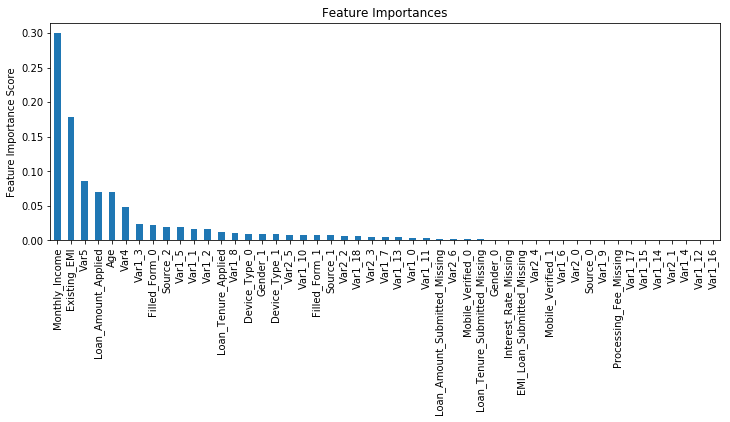

In [5]:
#Choose all predictors except target & IDcols
predictors = [x for x in train.columns if x not in [target, IDcol]]
gbm0 = GradientBoostingClassifier(random_state=10)
modelfit(gbm0, train, predictors)

***
### 调参的一般方法
***
学习率参数通常没有最优值, 因为对于更小的值, 在训练足够多子估计器的情况下能够很好的工作.

大致步骤:
1. 选择一个较大的学习率, 例如, 默认值0.1, 或者0.05-0.2之间, 这个视情况而定.
2. 选择最优训练轮数, 即: 子估计器个数.
3. 调节子估计器参数.
4. 降低学习率, 获得更稳定的模型.

### Fix learning rate and number of estimators for tuning tree-based parameters
***
为了调节 boosting 参数, 其它参数的初始值设置如下:

1. **`min_samples_split = 500`**: 大约是样本总量的 0.5-1% 左右, 又因为该问题的数据集类别不平衡, 所以取的稍小一些.

2. **`min_samples_leaf = 50`**: 凭直觉选取, 该参数仅仅用来控制过拟合; 同样的因为类别不平衡, 选择稍小的值.

3. **`max_depth = 8`**: 应该根据样本总量的大小和特征维度选择5-8之间的值. 这里样本总量为87000, 特征维度是49.

4. **`max_features = ‘sqrt’`**: 平方根通常是个不错的选择.

5. **`subsample = 0.8`**: 0.8通常作为初始值.

In [7]:
#Choose all predictors except target & IDcols
predictors = [x for x in train.columns if x not in [target, IDcol]]
param_test1 = {'n_estimators': list(range(20,81,10))}
gsearch1 = GridSearchCV(estimator = GradientBoostingClassifier(learning_rate=0.1, min_samples_split=500,min_samples_leaf=50,max_depth=8,max_features='sqrt',subsample=0.8,random_state=10), 
param_grid = param_test1, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gsearch1.fit(train[predictors],train[target])
gsearch1.grid_scores_, gsearch1.best_params_, gsearch1.best_score_

([mean: 0.83337, std: 0.00991, params: {'n_estimators': 20},
  mean: 0.83697, std: 0.00994, params: {'n_estimators': 30},
  mean: 0.83832, std: 0.01050, params: {'n_estimators': 40},
  mean: 0.83867, std: 0.01081, params: {'n_estimators': 50},
  mean: 0.83939, std: 0.01077, params: {'n_estimators': 60},
  mean: 0.83891, std: 0.01044, params: {'n_estimators': 70},
  mean: 0.83807, std: 0.01093, params: {'n_estimators': 80}],
 {'n_estimators': 60},
 0.8393875216177697)

***
### Tuning tree-specific parameters
***
分为以下几个阶段:
1. **`max_depth`**, **`min_samples_split`**
2. **`min_samples_leaf`**
3. **`max_features`**

参数的调节顺序很重要, 你应该先调节重要的参数.

In [8]:
param_test2 = {'max_depth': list(range(5,16,2)), 'min_samples_split': list(range(200,1001,200))}
gsearch2 = GridSearchCV(estimator = GradientBoostingClassifier(learning_rate=0.1, n_estimators=60, max_features='sqrt', subsample=0.8, random_state=10), 
param_grid = param_test2, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gsearch2.fit(train[predictors],train[target])
gsearch2.grid_scores_, gsearch2.best_params_, gsearch2.best_score_

([mean: 0.83297, std: 0.01226, params: {'max_depth': 5, 'min_samples_split': 200},
  mean: 0.83251, std: 0.01054, params: {'max_depth': 5, 'min_samples_split': 400},
  mean: 0.83386, std: 0.01415, params: {'max_depth': 5, 'min_samples_split': 600},
  mean: 0.83379, std: 0.01169, params: {'max_depth': 5, 'min_samples_split': 800},
  mean: 0.83339, std: 0.01266, params: {'max_depth': 5, 'min_samples_split': 1000},
  mean: 0.83392, std: 0.00758, params: {'max_depth': 7, 'min_samples_split': 200},
  mean: 0.83663, std: 0.00991, params: {'max_depth': 7, 'min_samples_split': 400},
  mean: 0.83481, std: 0.00826, params: {'max_depth': 7, 'min_samples_split': 600},
  mean: 0.83786, std: 0.01067, params: {'max_depth': 7, 'min_samples_split': 800},
  mean: 0.83769, std: 0.01060, params: {'max_depth': 7, 'min_samples_split': 1000},
  mean: 0.83581, std: 0.01003, params: {'max_depth': 9, 'min_samples_split': 200},
  mean: 0.83729, std: 0.00959, params: {'max_depth': 9, 'min_samples_split': 400},
  

In [9]:
param_test3 = {'min_samples_split': list(range(800,2100,200)), 'min_samples_leaf': list(range(30,71,10))}
gsearch3 = GridSearchCV(estimator = GradientBoostingClassifier(learning_rate=0.1, n_estimators=60,max_depth=9,max_features='sqrt', subsample=0.8, random_state=10), 
param_grid = param_test3, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gsearch3.fit(train[predictors],train[target])
gsearch3.grid_scores_, gsearch3.best_params_, gsearch3.best_score_

([mean: 0.83821, std: 0.01128, params: {'min_samples_leaf': 30, 'min_samples_split': 800},
  mean: 0.83821, std: 0.01092, params: {'min_samples_leaf': 30, 'min_samples_split': 1000},
  mean: 0.83889, std: 0.01271, params: {'min_samples_leaf': 30, 'min_samples_split': 1200},
  mean: 0.83552, std: 0.01024, params: {'min_samples_leaf': 30, 'min_samples_split': 1400},
  mean: 0.83683, std: 0.01429, params: {'min_samples_leaf': 30, 'min_samples_split': 1600},
  mean: 0.83958, std: 0.01233, params: {'min_samples_leaf': 30, 'min_samples_split': 1800},
  mean: 0.83852, std: 0.01097, params: {'min_samples_leaf': 30, 'min_samples_split': 2000},
  mean: 0.83701, std: 0.01214, params: {'min_samples_leaf': 40, 'min_samples_split': 800},
  mean: 0.83851, std: 0.00908, params: {'min_samples_leaf': 40, 'min_samples_split': 1000},
  mean: 0.83757, std: 0.01274, params: {'min_samples_leaf': 40, 'min_samples_split': 1200},
  mean: 0.83757, std: 0.01074, params: {'min_samples_leaf': 40, 'min_samples_split


Model Report
Accuracy : 0.9854
AUC Score (Train): 0.896453
CV Score : Mean - 0.8397598 | Std - 0.009936017 | Min - 0.8255474 | Max - 0.8527672


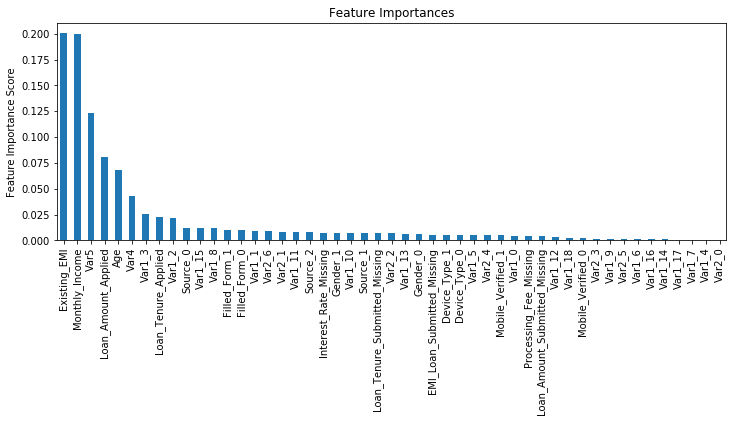

In [10]:
modelfit(gsearch3.best_estimator_, train, predictors)

In [11]:
param_test4 = {'max_features': list(range(7,20,2))}
gsearch4 = GridSearchCV(estimator = GradientBoostingClassifier(learning_rate=0.1, n_estimators=60,max_depth=9, min_samples_split=1200, min_samples_leaf=60, subsample=0.8, random_state=10),
param_grid = param_test4, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gsearch4.fit(train[predictors],train[target])
gsearch4.grid_scores_, gsearch4.best_params_, gsearch4.best_score_

([mean: 0.83976, std: 0.00994, params: {'max_features': 7},
  mean: 0.83648, std: 0.00988, params: {'max_features': 9},
  mean: 0.83919, std: 0.01042, params: {'max_features': 11},
  mean: 0.83738, std: 0.01017, params: {'max_features': 13},
  mean: 0.83898, std: 0.01101, params: {'max_features': 15},
  mean: 0.83495, std: 0.00931, params: {'max_features': 17},
  mean: 0.83524, std: 0.01018, params: {'max_features': 19}],
 {'max_features': 7},
 0.839759762884295)

***
子估计器参数的最终值是:
* **`min_samples_split=1200`**
* **`min_samples_leaf=60`**
* **`max_depth=9`**
* **`max_features=7`**

### Tuning **`subsample`** and making models with lower learning rate
***

In [12]:
param_test5 = {'subsample':[0.6,0.7,0.75,0.8,0.85,0.9]}
gsearch5 = GridSearchCV(estimator = GradientBoostingClassifier(learning_rate=0.1, n_estimators=60,max_depth=9,min_samples_split=1200, min_samples_leaf=60, subsample=0.8, random_state=10,max_features=7),
param_grid = param_test5, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gsearch5.fit(train[predictors],train[target])
gsearch5.grid_scores_, gsearch5.best_params_, gsearch5.best_score_

([mean: 0.83645, std: 0.00942, params: {'subsample': 0.6},
  mean: 0.83629, std: 0.01185, params: {'subsample': 0.7},
  mean: 0.83601, std: 0.01074, params: {'subsample': 0.75},
  mean: 0.83976, std: 0.00994, params: {'subsample': 0.8},
  mean: 0.84086, std: 0.00997, params: {'subsample': 0.85},
  mean: 0.83828, std: 0.00984, params: {'subsample': 0.9}],
 {'subsample': 0.85},
 0.840858008321874)

现在是时候减小学习率了.


Model Report
Accuracy : 0.9854
AUC Score (Train): 0.897619
CV Score : Mean - 0.8391332 | Std - 0.009437997 | Min - 0.8271238 | Max - 0.8511221


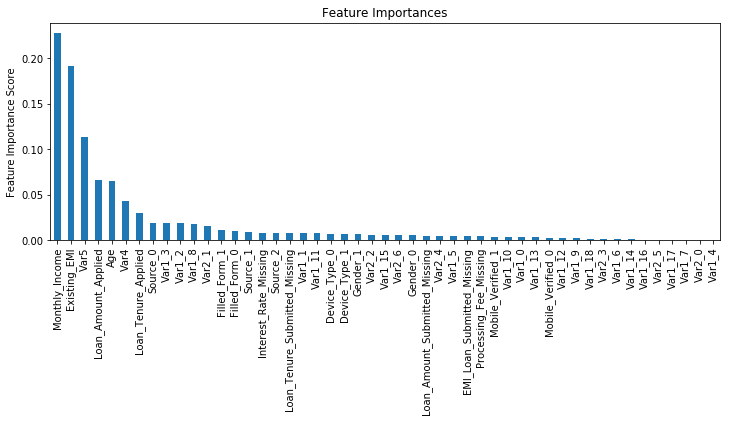

In [13]:
predictors = [x for x in train.columns if x not in [target, IDcol]]
gbm_tuned_1 = GradientBoostingClassifier(learning_rate=0.05, n_estimators=120,max_depth=9, min_samples_split=1200,min_samples_leaf=60, subsample=0.85, random_state=10, max_features=7)
modelfit(gbm_tuned_1, train, predictors)


Model Report
Accuracy : 0.9854
AUC Score (Train): 0.899962
CV Score : Mean - 0.8407913 | Std - 0.01011421 | Min - 0.8255379 | Max - 0.8522251


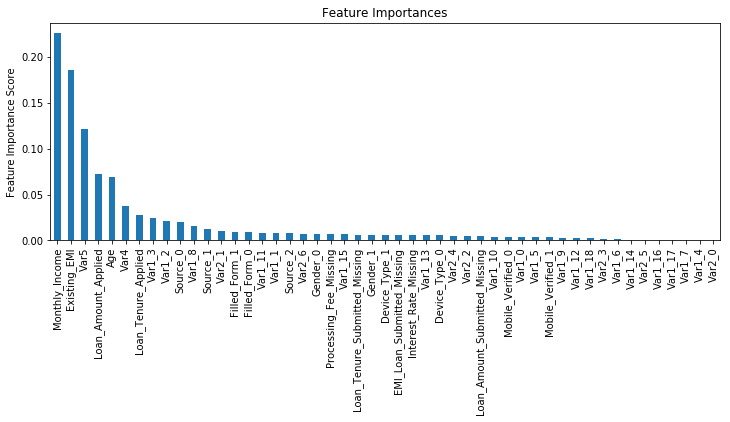

In [14]:
predictors = [x for x in train.columns if x not in [target, IDcol]]
gbm_tuned_2 = GradientBoostingClassifier(learning_rate=0.01, n_estimators=600,max_depth=9, min_samples_split=1200,min_samples_leaf=60, subsample=0.85, random_state=10, max_features=7)
modelfit(gbm_tuned_2, train, predictors)